# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import numpy as np
import random


import custom_resnet

from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from modular.create_data_loader import create_train_data_loader, create_test_data_loader
from modular.dataloader import Cifar10SearchDataset
from modular.transforms import CustomResnetTransforms
from modular.train import model_training, model_testing
from modular.plots import plot_losses,plot_images 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Transformation of Data

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

# Dataset and Creating Train/Test Split

In [5]:
train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=1024, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

print (len(train_loader),len(test_loader))

49 10


# Model Params for Custom Resnet
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
m = custom_resnet.resnet_model().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


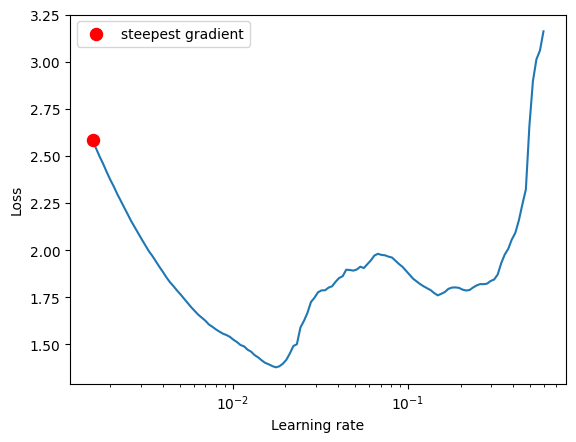

SystemExit: 

In [8]:
m = custom_resnet.resnet_model().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(m, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [9]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.59E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start= 5.0/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear',
    )


In [11]:
for epoch in range(EPOCHS):
    print("EPOCH: "+ str(epoch)),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing(m, device, test_loader, criterion)

EPOCH: 0


Loss=1.3135943412780762 LR =0.00033201024590163937 Batch_id=48 Accuracy=40.02: 100% 49/49 [00:08<00:00,  5.78it/s]



Test set: Average loss: 0.0013, Accuracy: 5290/10000 (52.90%)

EPOCH: 1


Loss=0.988410234451294 LR =0.0006481204918032787 Batch_id=48 Accuracy=61.65: 100% 49/49 [00:08<00:00,  5.73it/s]  



Test set: Average loss: 0.0012, Accuracy: 5980/10000 (59.80%)

EPOCH: 2


Loss=0.7498395442962646 LR =0.000964230737704918 Batch_id=48 Accuracy=70.83: 100% 49/49 [00:08<00:00,  5.66it/s] 



Test set: Average loss: 0.0010, Accuracy: 6696/10000 (66.96%)

EPOCH: 3


Loss=0.6602032780647278 LR =0.0012803409836065574 Batch_id=48 Accuracy=76.05: 100% 49/49 [00:08<00:00,  5.68it/s]



Test set: Average loss: 0.0007, Accuracy: 7772/10000 (77.72%)

EPOCH: 4


Loss=0.60640949010849 LR =0.001588292329752954 Batch_id=48 Accuracy=79.73: 100% 49/49 [00:08<00:00,  5.73it/s]   



Test set: Average loss: 0.0007, Accuracy: 7722/10000 (77.22%)

EPOCH: 5


Loss=0.4685296416282654 LR =0.0015046164876476907 Batch_id=48 Accuracy=82.27: 100% 49/49 [00:08<00:00,  5.83it/s] 



Test set: Average loss: 0.0005, Accuracy: 8249/10000 (82.49%)

EPOCH: 6


Loss=0.4209630787372589 LR =0.0014209406455424275 Batch_id=48 Accuracy=85.00: 100% 49/49 [00:08<00:00,  5.80it/s] 



Test set: Average loss: 0.0005, Accuracy: 8189/10000 (81.89%)

EPOCH: 7


Loss=0.3536264896392822 LR =0.0013372648034371644 Batch_id=48 Accuracy=86.88: 100% 49/49 [00:08<00:00,  5.61it/s] 



Test set: Average loss: 0.0005, Accuracy: 8349/10000 (83.49%)

EPOCH: 8


Loss=0.4011352062225342 LR =0.0012535889613319012 Batch_id=48 Accuracy=88.23: 100% 49/49 [00:08<00:00,  5.65it/s] 



Test set: Average loss: 0.0006, Accuracy: 8112/10000 (81.12%)

EPOCH: 9


Loss=0.3385430872440338 LR =0.001169913119226638 Batch_id=48 Accuracy=89.56: 100% 49/49 [00:08<00:00,  5.95it/s]  



Test set: Average loss: 0.0005, Accuracy: 8470/10000 (84.70%)

EPOCH: 10


Loss=0.3460094928741455 LR =0.0010862372771213748 Batch_id=48 Accuracy=90.33: 100% 49/49 [00:08<00:00,  5.54it/s] 



Test set: Average loss: 0.0004, Accuracy: 8572/10000 (85.72%)

EPOCH: 11


Loss=0.27983731031417847 LR =0.0010025614350161118 Batch_id=48 Accuracy=91.15: 100% 49/49 [00:08<00:00,  5.65it/s]



Test set: Average loss: 0.0004, Accuracy: 8738/10000 (87.38%)

EPOCH: 12


Loss=0.2193937450647354 LR =0.0009188855929108486 Batch_id=48 Accuracy=91.95: 100% 49/49 [00:09<00:00,  5.31it/s] 



Test set: Average loss: 0.0004, Accuracy: 8740/10000 (87.40%)

EPOCH: 13


Loss=0.18062730133533478 LR =0.0008352097508055854 Batch_id=48 Accuracy=92.80: 100% 49/49 [00:08<00:00,  5.58it/s]



Test set: Average loss: 0.0004, Accuracy: 8766/10000 (87.66%)

EPOCH: 14


Loss=0.20091137290000916 LR =0.0007515339087003222 Batch_id=48 Accuracy=93.36: 100% 49/49 [00:09<00:00,  5.12it/s]



Test set: Average loss: 0.0003, Accuracy: 8907/10000 (89.07%)

EPOCH: 15


Loss=0.16897088289260864 LR =0.0006678580665950591 Batch_id=48 Accuracy=94.13: 100% 49/49 [00:08<00:00,  5.56it/s]



Test set: Average loss: 0.0003, Accuracy: 9000/10000 (90.00%)

EPOCH: 16


Loss=0.1903616338968277 LR =0.0005841822244897958 Batch_id=48 Accuracy=94.71: 100% 49/49 [00:08<00:00,  5.86it/s] 



Test set: Average loss: 0.0003, Accuracy: 8932/10000 (89.32%)

EPOCH: 17


Loss=0.1531652957201004 LR =0.0005005063823845328 Batch_id=48 Accuracy=95.20: 100% 49/49 [00:08<00:00,  5.59it/s] 



Test set: Average loss: 0.0003, Accuracy: 8937/10000 (89.37%)

EPOCH: 18


Loss=0.13625195622444153 LR =0.00041683054027926965 Batch_id=48 Accuracy=95.98: 100% 49/49 [00:08<00:00,  5.71it/s]



Test set: Average loss: 0.0003, Accuracy: 9087/10000 (90.87%)

EPOCH: 19


Loss=0.11031597852706909 LR =0.00033315469817400646 Batch_id=48 Accuracy=96.66: 100% 49/49 [00:08<00:00,  5.68it/s]



Test set: Average loss: 0.0003, Accuracy: 9051/10000 (90.51%)

EPOCH: 20


Loss=0.0942598283290863 LR =0.00024947885606874326 Batch_id=48 Accuracy=97.32: 100% 49/49 [00:09<00:00,  5.26it/s] 



Test set: Average loss: 0.0003, Accuracy: 9158/10000 (91.58%)

EPOCH: 21


Loss=0.07662304490804672 LR =0.00016580301396348029 Batch_id=48 Accuracy=97.93: 100% 49/49 [00:08<00:00,  5.56it/s] 



Test set: Average loss: 0.0003, Accuracy: 9185/10000 (91.85%)

EPOCH: 22


Loss=0.05856219679117203 LR =8.212717185821687e-05 Batch_id=48 Accuracy=98.32: 100% 49/49 [00:08<00:00,  5.57it/s]  



Test set: Average loss: 0.0002, Accuracy: 9221/10000 (92.21%)

EPOCH: 23


Loss=0.042819224298000336 LR =-1.5486702470463194e-06 Batch_id=48 Accuracy=98.64: 100% 49/49 [00:09<00:00,  5.15it/s]



Test set: Average loss: 0.0002, Accuracy: 9239/10000 (92.39%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


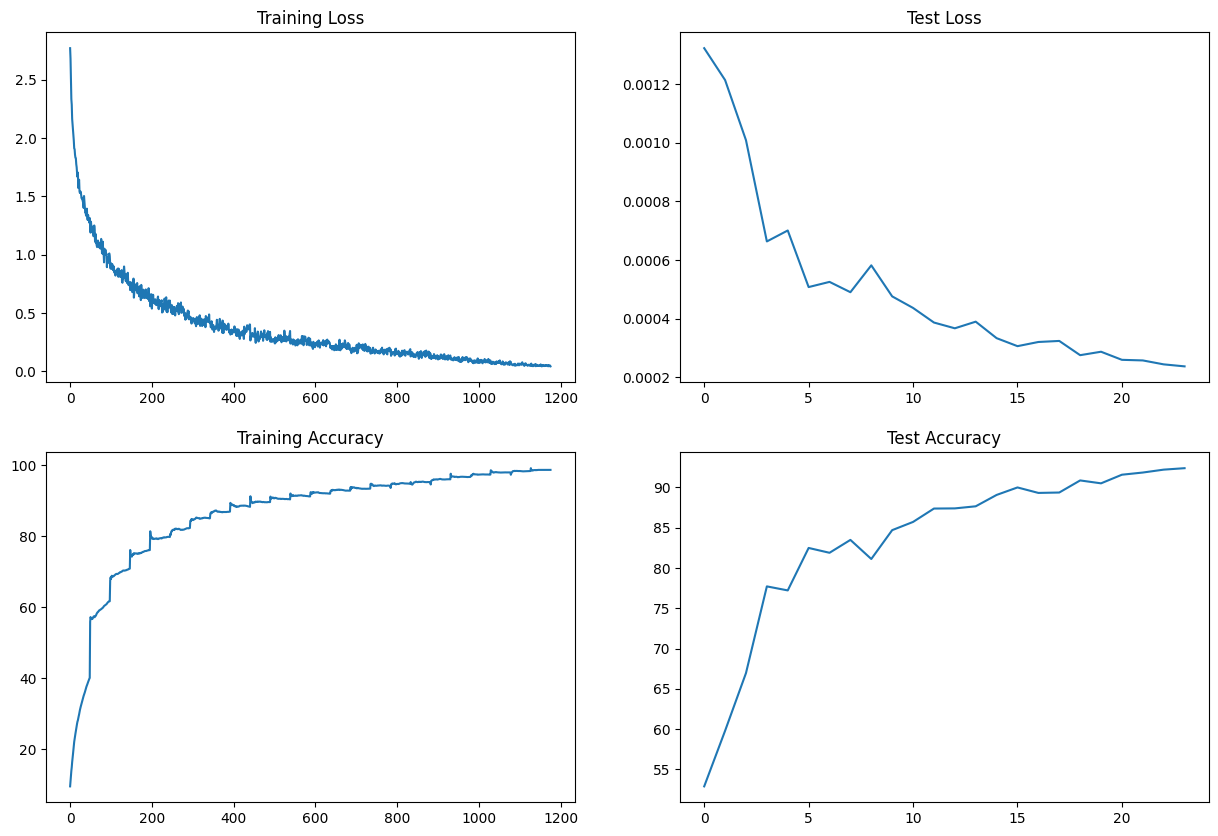

In [12]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

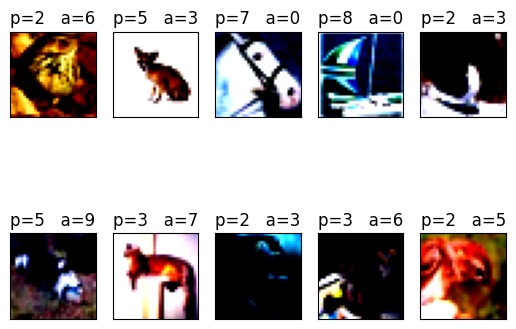

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_images = range(0,len(miss_classified_data[0]))
random_selects = random.sample(random_images, 10)

fig_miss_class = plt.figure()
count=0
for i in random_selects:
    plt.subplot(2,5,count+1)
    plt.imshow(miss_classified_data[2][i].cpu().permute(1,2,0))   
    plt.title("p="+str(miss_classified_data[1][i])+"   "+"a="+str(miss_classified_data[0][i]))
    plt.xticks([])
    plt.yticks([])
    count+=1

fig_miss_class.savefig("images/mis_classified_image.jpg")

## Displaying Sample Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

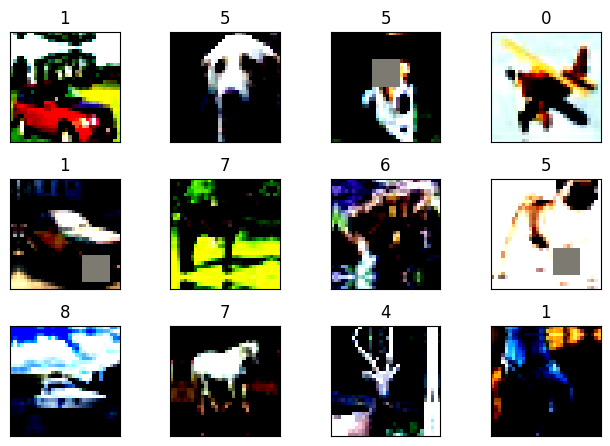

In [14]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

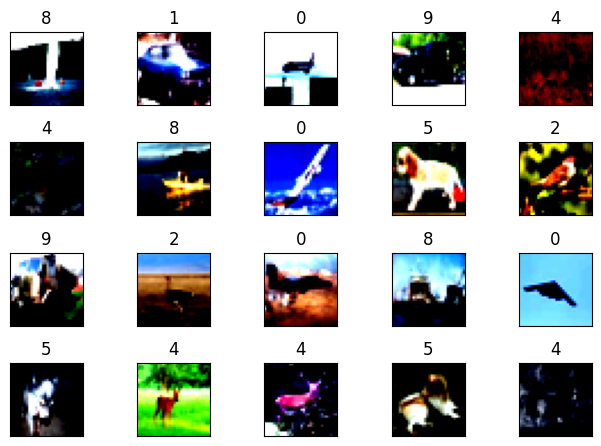

In [15]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

**********************************************************